# Set up

In [316]:
## prepare packages
#%pip install -U pandas
#%pip install -U matplotlib
#%pip install -U gensim
#%pip install -U scipy
#%pip install -U pyLDAvis
#%pip install -U plotly
#%pip install -U 'nbformat>=4.2.0'

In [317]:
## import modules
import os, sys
## maake accessible files on level immediately above 
sys.path.append(os.path.join(os.path.dirname("__file__"), ".."))
## import other modules
import re
import gzip, glob
import unicodedata

# Preparation 1

In [318]:
## parameters
verbose              = True
save_results         = False
targets_csv          = True
## source sampling
source_sampling      = True
source_sampling_rate = 0.03 # optimal values depend on kinds of source
## doc settings # The longer sentences become, the less precise pairing becomes
size_measures        = ['sp_word_size', 'sn_word_size']
size_measure         = size_measures[1]
min_doc_size         = 4 # larger value avoids Sum not equals 1 error
max_doc_size         = 9
add_boundaries       = False
boundary_symbol      = '#'
lower_chars          = True
strip_accents        = True
## term settings
ngram_is_inclusive    = True # takes significantly more time to complete but invites sum error if False with larger n, 
ngram_is_minimally_inclusive = True
max_gap_val           = round(max_doc_size * 0.5) # This needs to be smaller than other cases.
## Skippy n-gram の隙間を表わす記号
gap_marker            = "…"
## spell term と sound term の連結記号
pair_marker           = " :: "
## set spell term_type
sp_term_types  = [ 'sp_1gram',
                  'sp_2gram', 'sp_3gram', 'sp_4gram', 'sp_5gram',
                 'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ]
sp_term_type   = sp_term_types[-1]
## set sound term_type
sn_term_types = [ 'sn_1gram',
                 'sn_2gram', 'sn_3gram', 'sn_4gram', 'sn_5gram',
                 'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]
sn_term_type = sn_term_types[-1]
print(f"sp_term_type: {sp_term_type}")
print(f"sn_term_type: {sn_term_type}")

sp_term_type: sp_skippy4gram
sn_term_type: sn_skippy4gram


In [319]:
## term filtering: some combinations cause "Not all rows sum to 1" error with HDP, but no with LDA
apply_term_freq_filtering  = True
term_minfreq         = 3 # Effective for speeding up
apply_term_abuse_filtering = True
term_abuse_threshold = 0.01 # Larger values reveal dependencies at deeper layers; 0.006 seems to be the smallest
## Either one often causes "Not all rows (distributions) in doc_topic_dists sum to 1" with HDP.
apply_bot_size_filtering = False # This is likely to be offensive: Use with caution
min_bot_size = 1

In [320]:
## select HDP or LDA: HDP takes considerably longer than LDA,
## and is susceptible with "Not all rows sum to 1" error at pyLDAvis
use_HDP       = True
max_n_topics  = 90 # Large values often fail on pyLDAvis with "Not all rows sum = 1" error
## LDA
n_topics  = round(max_n_topics * 0.67) # 精度にはあまり影響しない？
if use_HDP:
    method_name  = "HDP" # non-executive variable to be used in file names
else:
    method_name  = "LDA"
## tSNE
top_perplexity_reduct_rate = 0.33
##
print(f"method_name: {method_name}")
print(f"max_n_topics for HDP: {max_n_topics}")
print(f"n_topics for LDA: {n_topics}")
print(f"top_perplexity_reduct_rate: {top_perplexity_reduct_rate}")

method_name: HDP
max_n_topics for HDP: 90
n_topics for LDA: 60
top_perplexity_reduct_rate: 0.33


In [321]:
## get data
import glob
data_dir1 = "data/open-dict-ipa/data1"
data_dir2 = "data/open-dict-ipa/data1a"
files = []
for dir in [ data_dir1, data_dir2 ]:
    gz_files = glob.glob(f"{dir}/*.gz")
    files.extend(gz_files)
    csv_files = glob.glob(f"{dir}/*.csv")
    files.extend(csv_files)
    txt_files = glob.glob(f"{data_dir2}/*.txt")
    files.extend(txt_files)
#
files

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_N.csv.gz',
 'data/open-dict-ipa/data1/j

In [322]:
## select language and file
lang_names = {  'en' : 'English',
                'de' : 'German',
                'fr' : 'French'
            }
#
lang_keys = [ 'en', 'de', 'fr' ]
lang_key = lang_keys[0]
lang_name = lang_names[lang_key]
print(f"lang_name: {lang_name} [lang_key: {lang_key}]")
#
files = [ file for file in files if f"/{lang_key}" in file ]
print(files)
#
target_attr = "US"
if len(target_attr) > 0:
    print(f"target_attr: {target_attr}")
    selected_files = [ file for file in files if target_attr in file ]
else:
    selected_files = files
selected_files

lang_name: English [lang_key: en]
['data/open-dict-ipa/data1/en_US.csv.gz', 'data/open-dict-ipa/data1/en_UK.csv.gz']
target_attr: US


['data/open-dict-ipa/data1/en_US.csv.gz']

In [323]:
## build data from files
import re, unicodedata
import pandas as pd
check = False
col_names = [ 'sp_word', 'sn_word' ]
for j, target_file in enumerate(selected_files):
    if target_file.endswith(".gz"):
        with gzip.open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
    else:
        with open(target_file, "rt") as f:
            raw_df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
#
raw_df

,sp_word,sn_word
0,'bout,/ˈbaʊt/
1,'cause,/kəz/
2,'course,/ˈkɔɹs/
3,'cuse,/ˈkjuz/
4,'em,/əm/
...,...,...
125922,zysk,/ˈzaɪsk/
125923,zyskowski,/zɪˈskɔfski/
125924,zyuganov,"/ˈzjuɡɑnɑv/, /ˈzuɡɑnɑv/"
125925,zyuganov's,"/ˈzjuɡɑnɑvz/, /ˈzuɡɑnɑvz/"


In [324]:
## modify spell
raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
if lower_chars:
    raw_df['sp_word'] = raw_df['sp_word'].apply(lambda x: x.lower())

## modify sound symbols
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: unicodedata.normalize('NFC', str(x)))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"/", "", x))
raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: x.split(",")[0]) # pick up only the first
if strip_accents:
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r'"', "", x))
    raw_df['sn_word'] = raw_df['sn_word'].apply(lambda x: re.sub(r"[ˈˌ]", "", x))
#
raw_df

,sp_word,sn_word
0,'bout,baʊt
1,'cause,kəz
2,'course,kɔɹs
3,'cuse,kjuz
4,'em,əm
...,...,...
125922,zysk,zaɪsk
125923,zyskowski,zɪskɔfski
125924,zyuganov,zjuɡɑnɑv
125925,zyuganov's,zjuɡɑnɑvz


In [325]:
## build df
dids = [ ]
sids = [ ]
Spells = [ ]
Sounds = [ ]
for i, row in raw_df.iterrows():
    spell = row['sp_word']
    sound = row['sn_word']
    if len(spell) > 0 and len(sound) > 0:
        dids.append(j + 1)
        sids.append(i + 1)
        Spells.append(spell)
        Sounds.append(sound)
#
var_names = [ 'did', 'sid', 'sp_word', 'sn_word',
            'sp_word_size', 'sn_word_size', 'paired_terms', 
            'sp_1gram', 'sp_2gram', 'sp_3gram',
            'sp_skippy2gram', 'sp_skippy3gram',
            'sn_1gram', 'sn_2gram', 'sn_3gram', 
            'sn_skippy2gram', 'sn_skippy3gram' ]
df = pd.DataFrame()
df['did'] = dids
df['sid'] = sids
df['sp_word'] = Spells
df['sn_word'] = Sounds
#
df[var_names[:4]]

,did,sid,sp_word,sn_word
0,1,1,'bout,baʊt
1,1,2,'cause,kəz
2,1,3,'course,kɔɹs
3,1,4,'cuse,kjuz
4,1,5,'em,əm
...,...,...,...,...
125922,1,125923,zysk,zaɪsk
125923,1,125924,zyskowski,zɪskɔfski
125924,1,125925,zyuganov,zjuɡɑnɑv
125925,1,125926,zyuganov's,zjuɡɑnɑvz


In [326]:
## sampling
if source_sampling:
    original_size = len(df)
    sample_size = round(len(df) * source_sampling_rate)
    df = df.sample(sample_size)
    print(f"sampled {len(df)} ({source_sampling_rate:0.3f}) rows by discarding {original_size - len(df)} rows")

sampled 3778 (0.030) rows by discarding 122149 rows


In [327]:
## tokenization
import gzip, re
import pandas as pd
check = False
Snx = [ ]
Spx = [ ]
for i, row in df.iterrows():
    Spt = row['sp_word']
    Snt = row['sn_word']
    split_pattern = r""
    ## Spell
    sp_seg = [ x for x in re.split(split_pattern, Spt) if len(x) > 0 ]
    if check:
        print(sp_seg)
    Spx.append(sp_seg)
    ## Sound
    sn_seg = [ x for x in re.split(split_pattern, Snt) if len(x) > 0 ]
    if check:
        print(sn_seg)
    Snx.append(sn_seg)
## Spell
try:
    df['sp_1gram'] = Spx
except ValueError:
    pass
## Sound
try:
    df['sn_1gram'] = Snx
except ValueError:
    pass
## check result
if verbose:
    df

In [328]:
## add size columns
df['sp_word_size'] = df['sp_1gram'].apply(lambda x: len(x))
df['sn_word_size'] = df['sn_1gram'].apply(lambda x: len(x))
if verbose:
    df

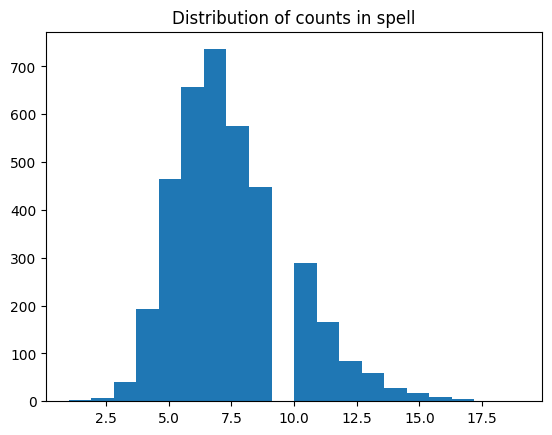

In [329]:
## 語の綴り文字数の分布
import matplotlib.pyplot as plt
plt.hist(df['sp_word_size'], bins = 20)
plt.title(f"Distribution of counts in spell")
plt.show()

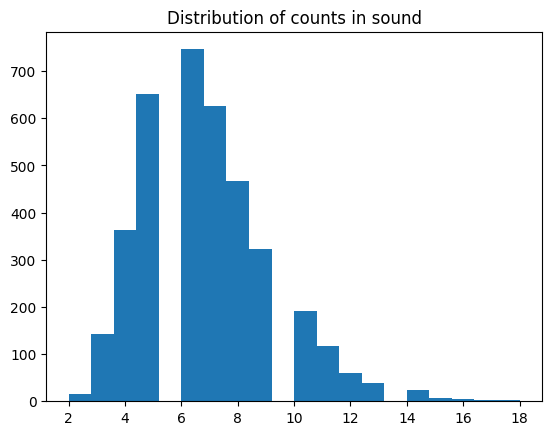

In [330]:
## 語の発音記号数の分布
import matplotlib.pyplot as plt
plt.hist(df['sn_word_size'], bins = 20)
plt.title(f"Distribution of counts in sound")
plt.show()

# build terms, part 1

In [331]:
## 長さで濾過
original_size = len(df)
print(f"discarding pairs whose {size_measure} part has less than {min_doc_size} chars")
df = df[df[size_measure] >= min_doc_size]

print(f"discarding pairs whose {size_measure} part has more than {max_doc_size} chars")
df = df[df[size_measure] < max_doc_size]

current_size = len(df)
size_diff = original_size - current_size
print(f"{size_diff} ({size_diff/original_size:.3f}) pairs were removed")
print(f"{current_size} pairs remain")

discarding pairs whose sn_word_size part has less than 4 chars
discarding pairs whose sn_word_size part has more than 9 chars
925 (0.245) pairs were removed
2853 pairs remain


In [332]:
## add boundaries
if add_boundaries:
    df['sp_word'] = df['sp_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df['sn_word'] = df['sn_word'].apply(lambda x: f"{boundary_symbol}{x}{boundary_symbol}")
    df[['sp_word', 'sn_word']]

In [333]:
## add 1gram
import re
w_splitter = r""
df['sp_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sp_word'] ]
df['sn_1gram'] = [ [ x for x in re.split(w_splitter, w) if len(x) > 0 ] for w in df['sn_word'] ]
df[['sp_1gram', 'sn_1gram']]

,sp_1gram,sn_1gram
66038,"[l, i, p, s, k, i]","[ɫ, ɪ, p, s, k, i]"
61931,"[k, r, e, i, g, e, r]","[k, ɹ, a, ɪ, ɡ, ɝ]"
100883,"[s, e, d, u, c, t, i, v, e]","[s, ɪ, d, ə, k, t, ɪ, v]"
115063,"[t, r, a, s, h, e, s]","[t, ɹ, æ, ʃ, ɪ, z]"
27310,"[d, e, b, e, s]","[d, i, b, z]"
...,...,...
63955,"[l, a, u, t, e, r]","[ɫ, a, ʊ, t, ɝ]"
53716,"[h, u, t, s, o, n]","[h, ə, t, s, ə, n]"
123452,"[w, i, t, k, o, p]","[w, ɪ, t, k, ə, p]"
64112,"[l, a, y, o, f, f]","[ɫ, e, ɪ, ɔ, f]"


In [334]:
## inspect frequent tokens in sp_1gram
from collections import Counter
sp_chars_all = [ ] 
[ sp_chars_all.extend(list(x)) for x in df['sp_1gram'] ]
sp_char_freqs = Counter(sp_chars_all)
## Show most frequent 10 segments
sｐ_char_freqs.most_common(10)

[('e', 2269),
 ('a', 1698),
 ('r', 1563),
 ('s', 1498),
 ('i', 1343),
 ('n', 1306),
 ('o', 1200),
 ('l', 1170),
 ('t', 1008),
 ('d', 694)]

In [335]:
## inspect frequent tokens in sn_1gram
from collections import Counter
sn_chars_all = [ ] 
[ sn_chars_all.extend(list(x)) for x in df['sn_1gram'] ]
sn_char_freqs = Counter(sn_chars_all)
## Show most frequent 10 segments
sn_char_freqs.most_common(10)

[('ɪ', 1362),
 ('ə', 1181),
 ('n', 1062),
 ('ɫ', 1015),
 ('s', 944),
 ('t', 912),
 ('ɹ', 861),
 ('k', 859),
 ('d', 744),
 ('i', 677)]

In [336]:
## Install nltk if necessary
#!pip install -U nltk

n-grams の構築

In [337]:
def gen_ngrams_from_str(t: str, n: int, sep: str = r"", joint: str = "", check = False):
    'returns the list of character n-grams from a given string'
    import re
    segs = [ x for x in re.split(sep, t) if len(x) > 0 ]
    if check:
        print(segs)
    ## short input
    if len(segs) <= n:
        return segs
    ## long enough input
    G = [ ]
    for i in range(len(segs)):
        try:
            b = segs[ i : i + n ]
            if check:
                print(b)
            c = joint.join(b)
            if check:
                print(c)
            if len(c) == n:
                G.append(c)
        except IndexError:
            pass
    return G

In [338]:
## spell 2-gram
import ngrams
n_for_ngram = 2
sp_2grams = [ gen_ngrams_from_str(w, n = n_for_ngram, check = False) for w in df['sp_word'] ]
## make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_2grams):
        gram.extend(list(df['sp_1gram'])[i])
## update df
df['sp_2gram'] = sp_2grams
df['sp_2gram']

66038                [li, ip, ps, sk, ki, l, i, p, s, k, i]
61931         [kr, re, ei, ig, ge, er, k, r, e, i, g, e, r]
100883    [se, ed, du, uc, ct, ti, iv, ve, s, e, d, u, c...
115063        [tr, ra, as, sh, he, es, t, r, a, s, h, e, s]
27310                       [de, eb, be, es, d, e, b, e, s]
                                ...                        
63955                [la, au, ut, te, er, l, a, u, t, e, r]
53716                [hu, ut, ts, so, on, h, u, t, s, o, n]
123452               [wi, it, tk, ko, op, w, i, t, k, o, p]
64112                [la, ay, yo, of, ff, l, a, y, o, f, f]
61598                [ko, or, rs, so, on, k, o, r, s, o, n]
Name: sp_2gram, Length: 2853, dtype: object

In [339]:
## spell 3-gram
import ngrams
n_for_ngram = 3
sp_3grams = [ gen_ngrams_from_str(w, n = n_for_ngram, check = False) for w in df['sp_word'] ]
## make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_3grams):
        supplement = list(df['sp_2gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sp_3gram'] = sp_3grams
df['sp_3gram']

66038              [lip, ips, psk, ski, li, ip, ps, sk, ki]
61931     [kre, rei, eig, ige, ger, kr, re, ei, ig, ge, er]
100883    [sed, edu, duc, uct, cti, tiv, ive, se, ed, du...
115063    [tra, ras, ash, she, hes, tr, ra, as, sh, he, es]
27310                       [deb, ebe, bes, de, eb, be, es]
                                ...                        
63955              [lau, aut, ute, ter, la, au, ut, te, er]
53716              [hut, uts, tso, son, hu, ut, ts, so, on]
123452             [wit, itk, tko, kop, wi, it, tk, ko, op]
64112              [lay, ayo, yof, off, la, ay, yo, of, ff]
61598              [kor, ors, rso, son, ko, or, rs, so, on]
Name: sp_3gram, Length: 2853, dtype: object

In [340]:
## spell 4-gram
import ngrams
n_for_ngram = 4
sp_4grams = [ gen_ngrams_from_str(w, n = n_for_ngram, check = False) for w in df['sp_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_4grams):
        supplement = list(df['sp_3gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sp_4gram'] = sp_4grams
df['sp_4gram']

66038                [lips, ipsk, pski, lip, ips, psk, ski]
61931     [krei, reig, eige, iger, kre, rei, eig, ige, ger]
100883    [sedu, educ, duct, ucti, ctiv, tive, sed, edu,...
115063    [tras, rash, ashe, shes, tra, ras, ash, she, hes]
27310                           [debe, ebes, deb, ebe, bes]
                                ...                        
63955                [laut, aute, uter, lau, aut, ute, ter]
53716                [huts, utso, tson, hut, uts, tso, son]
123452               [witk, itko, tkop, wit, itk, tko, kop]
64112                [layo, ayof, yoff, lay, ayo, yof, off]
61598                [kors, orso, rson, kor, ors, rso, son]
Name: sp_4gram, Length: 2853, dtype: object

In [341]:
## spell 5-gram
import ngrams
n_for_ngram = 5
sp_5grams = [ gen_ngrams_from_str(w, n = n_for_ngram, check = False) for w in df['sp_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_5grams):
        supplement = list(df['sp_4gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sp_5gram'] = sp_5grams
df['sp_5gram']

66038                      [lipsk, ipski, lips, ipsk, pski]
61931         [kreig, reige, eiger, krei, reig, eige, iger]
100883    [seduc, educt, ducti, uctiv, ctive, sedu, educ...
115063        [trash, rashe, ashes, tras, rash, ashe, shes]
27310                           [d, e, b, e, s, debe, ebes]
                                ...                        
63955                      [laute, auter, laut, aute, uter]
53716                      [hutso, utson, huts, utso, tson]
123452                     [witko, itkop, witk, itko, tkop]
64112                      [layof, ayoff, layo, ayof, yoff]
61598                      [korso, orson, kors, orso, rson]
Name: sp_5gram, Length: 2853, dtype: object

In [342]:
## spell skippy 2-gram
import ngrams_skippy
n_for_ngram = 2
sp_skippy2grams = [ ngrams_skippy.gen_skippy_2grams(x, sep = "",
                                                        max_distance = max_gap_val,
                                                        missing_mark = gap_marker) for x in df['sp_1gram'] ]
## make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_skippy2grams):
        gram.extend(list(df['sp_1gram'])[i])
## update df
df['sp_skippy2gram'] = sp_skippy2grams
df['sp_skippy2gram']

66038     [li, l…p, l…s, l…k, ip, i…s, i…k, i…i, ps, p…k...
61931     [kr, k…e, k…i, k…g, re, r…i, r…g, r…e, ei, e…g...
100883    [se, s…d, s…u, s…c, ed, e…u, e…c, e…t, du, d…c...
115063    [tr, t…a, t…s, t…h, ra, r…s, r…h, r…e, as, a…h...
27310     [de, d…b, d…e, d…s, eb, e…e, e…s, be, b…s, es,...
                                ...                        
63955     [la, l…u, l…t, l…e, au, a…t, a…e, a…r, ut, u…e...
53716     [hu, h…t, h…s, h…o, ut, u…s, u…o, u…n, ts, t…o...
123452    [wi, w…t, w…k, w…o, it, i…k, i…o, i…p, tk, t…o...
64112     [la, l…y, l…o, l…f, ay, a…o, a…f, yo, y…f, of,...
61598     [ko, k…r, k…s, k…o, or, o…s, o…o, o…n, rs, r…o...
Name: sp_skippy2gram, Length: 2853, dtype: object

In [343]:
## spell skippy 3-gram
import ngrams_skippy
n_for_ngram = 3
sp_skippy3grams = [ ngrams_skippy.gen_skippy_3grams(x, sep = "",
                                                        max_distance = max_gap_val,
                                                        missing_mark = gap_marker) for x in df['sp_1gram'] ]

## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_skippy3grams):
        supplement = list(df['sp_skippy2gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update
df['sp_skippy3gram'] = sp_skippy3grams
df['sp_skippy3gram']

66038     [lip, li…s, li…k, l…ps, l…p…k, l…sk, ips, ip…k...
61931     [kre, kr…i, kr…g, k…ei, k…e…g, k…ig, rei, re…g...
100883    [sed, se…u, se…c, s…du, s…d…c, s…uc, edu, ed…c...
115063    [tra, tr…s, tr…h, t…as, t…a…h, t…sh, ras, ra…h...
27310     [deb, de…e, de…s, d…be, d…b…s, d…es, ebe, eb…s...
                                ...                        
63955     [lau, la…t, la…e, l…ut, l…u…e, l…te, aut, au…e...
53716     [hut, hu…s, hu…o, h…ts, h…t…o, h…so, uts, ut…o...
123452    [wit, wi…k, wi…o, w…tk, w…t…o, w…ko, itk, it…o...
64112     [lay, la…o, la…f, l…yo, l…y…f, l…of, ayo, ay…f...
61598     [kor, ko…s, ko…o, k…rs, k…r…o, k…so, ors, or…o...
Name: sp_skippy3gram, Length: 2853, dtype: object

In [344]:
## spell skippy 4-gram
import ngrams_skippy
n_for_ngram = 4
sp_skippy4grams = [ ngrams_skippy.gen_skippy_4grams(x, sep = "",
                                                        max_distance = max_gap_val,
                                                        missing_mark = gap_marker) for x in df['sp_1gram'] ]

## make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sp_skippy4grams):
        supplement = list(df['sp_skippy3gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sp_skippy4gram'] = sp_skippy4grams
df['sp_skippy4gram']

66038     [lips, lip…k, li…sk, l…p…sk, ipsk, ips…i, ip…k...
61931     [krei, kre…g, kr…ig, k…e…ig, reig, rei…e, re…g...
100883    [sedu, sed…c, se…uc, s…d…uc, educ, edu…t, ed…c...
115063    [tras, tra…h, tr…sh, t…a…sh, rash, ras…e, ra…h...
27310     [debe, deb…s, de…es, d…b…es, ebes, deb, de…e, ...
                                ...                        
63955     [laut, lau…e, la…te, l…u…te, aute, aut…r, au…e...
53716     [huts, hut…o, hu…so, h…t…so, utso, uts…n, ut…o...
123452    [witk, wit…o, wi…ko, w…t…ko, itko, itk…p, it…o...
64112     [layo, lay…f, la…of, l…y…of, ayof, ayo…f, ay…f...
61598     [kors, kor…o, ko…so, k…r…so, orso, ors…n, or…o...
Name: sp_skippy4gram, Length: 2853, dtype: object

In [345]:
## check result
df[ [ 'sp_word', 'sp_skippy2gram', 'sp_skippy3gram', 'sp_skippy4gram' ] ]

,sp_word,sp_skippy2gram,sp_skippy3gram,sp_skippy4gram
66038,lipski,"[li, l…p, l…s, l…k, ip, i…s, i…k, i…i, ps, p…k...","[lip, li…s, li…k, l…ps, l…p…k, l…sk, ips, ip…k...","[lips, lip…k, li…sk, l…p…sk, ipsk, ips…i, ip…k..."
61931,kreiger,"[kr, k…e, k…i, k…g, re, r…i, r…g, r…e, ei, e…g...","[kre, kr…i, kr…g, k…ei, k…e…g, k…ig, rei, re…g...","[krei, kre…g, kr…ig, k…e…ig, reig, rei…e, re…g..."
100883,seductive,"[se, s…d, s…u, s…c, ed, e…u, e…c, e…t, du, d…c...","[sed, se…u, se…c, s…du, s…d…c, s…uc, edu, ed…c...","[sedu, sed…c, se…uc, s…d…uc, educ, edu…t, ed…c..."
115063,trashes,"[tr, t…a, t…s, t…h, ra, r…s, r…h, r…e, as, a…h...","[tra, tr…s, tr…h, t…as, t…a…h, t…sh, ras, ra…h...","[tras, tra…h, tr…sh, t…a…sh, rash, ras…e, ra…h..."
27310,debes,"[de, d…b, d…e, d…s, eb, e…e, e…s, be, b…s, es,...","[deb, de…e, de…s, d…be, d…b…s, d…es, ebe, eb…s...","[debe, deb…s, de…es, d…b…es, ebes, deb, de…e, ..."
...,...,...,...,...
63955,lauter,"[la, l…u, l…t, l…e, au, a…t, a…e, a…r, ut, u…e...","[lau, la…t, la…e, l…ut, l…u…e, l…te, aut, au…e...","[laut, lau…e, la…te, l…u…te, aute, aut…r, au…e..."
53716,hutson,"[hu, h…t, h…s, h…o, ut, u…s, u…o, u…n, ts, t…o...","[hut, hu…s, hu…o, h…ts, h…t…o, h…so, uts, ut…o...","[huts, hut…o, hu…so, h…t…so, utso, uts…n, ut…o..."
123452,witkop,"[wi, w…t, w…k, w…o, it, i…k, i…o, i…p, tk, t…o...","[wit, wi…k, wi…o, w…tk, w…t…o, w…ko, itk, it…o...","[witk, wit…o, wi…ko, w…t…ko, itko, itk…p, it…o..."
64112,layoff,"[la, l…y, l…o, l…f, ay, a…o, a…f, yo, y…f, of,...","[lay, la…o, la…f, l…yo, l…y…f, l…of, ayo, ay…f...","[layo, lay…f, la…of, l…y…of, ayof, ayo…f, ay…f..."


n-grams の構築

In [346]:
## sound 2-gram
import ngrams
sn_2grams = [ gen_ngrams_from_str(w, n = 2, sep = r"", check = False) for w in df['sn_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_2grams):
        gram.extend(list(df['sn_1gram'])[i])
## update df     
df['sn_2gram'] = sn_2grams
df['sn_2gram']

66038                [ɫɪ, ɪp, ps, sk, ki, ɫ, ɪ, p, s, k, i]
61931                [kɹ, ɹa, aɪ, ɪɡ, ɡɝ, k, ɹ, a, ɪ, ɡ, ɝ]
100883    [sɪ, ɪd, də, ək, kt, tɪ, ɪv, s, ɪ, d, ə, k, t,...
115063               [tɹ, ɹæ, æʃ, ʃɪ, ɪz, t, ɹ, æ, ʃ, ɪ, z]
27310                              [di, ib, bz, d, i, b, z]
                                ...                        
63955                       [ɫa, aʊ, ʊt, tɝ, ɫ, a, ʊ, t, ɝ]
53716                [hə, ət, ts, sə, ən, h, ə, t, s, ə, n]
123452               [wɪ, ɪt, tk, kə, əp, w, ɪ, t, k, ə, p]
64112                       [ɫe, eɪ, ɪɔ, ɔf, ɫ, e, ɪ, ɔ, f]
61598                [kɔ, ɔɹ, ɹs, sə, ən, k, ɔ, ɹ, s, ə, n]
Name: sn_2gram, Length: 2853, dtype: object

In [347]:
## sound 3-gram
import ngrams
n_for_ngram = 3
sn_3grams = [ gen_ngrams_from_str(w, n = n_for_ngram, sep = r"", check = False) for w in df['sn_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_3grams):
        supplement = list(df['sn_2gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sn_3gram'] = sn_3grams
df['sn_3gram']

66038              [ɫɪp, ɪps, psk, ski, ɫɪ, ɪp, ps, sk, ki]
61931              [kɹa, ɹaɪ, aɪɡ, ɪɡɝ, kɹ, ɹa, aɪ, ɪɡ, ɡɝ]
100883    [sɪd, ɪdə, dək, əkt, ktɪ, tɪv, sɪ, ɪd, də, ək,...
115063             [tɹæ, ɹæʃ, æʃɪ, ʃɪz, tɹ, ɹæ, æʃ, ʃɪ, ɪz]
27310                                [dib, ibz, di, ib, bz]
                                ...                        
63955                       [ɫaʊ, aʊt, ʊtɝ, ɫa, aʊ, ʊt, tɝ]
53716              [hət, əts, tsə, sən, hə, ət, ts, sə, ən]
123452             [wɪt, ɪtk, tkə, kəp, wɪ, ɪt, tk, kə, əp]
64112                       [ɫeɪ, eɪɔ, ɪɔf, ɫe, eɪ, ɪɔ, ɔf]
61598              [kɔɹ, ɔɹs, ɹsə, sən, kɔ, ɔɹ, ɹs, sə, ən]
Name: sn_3gram, Length: 2853, dtype: object

In [348]:
## sound 4-gram
import ngrams
n_for_ngram = 4
sn_4grams = [ gen_ngrams_from_str(w, n = n_for_ngram, sep = r"", check = False) for w in df['sn_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_4grams):
        supplement = list(df['sn_3gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sn_4gram'] = sn_4grams
df['sn_4gram']

66038                [ɫɪps, ɪpsk, pski, ɫɪp, ɪps, psk, ski]
61931                [kɹaɪ, ɹaɪɡ, aɪɡɝ, kɹa, ɹaɪ, aɪɡ, ɪɡɝ]
100883    [sɪdə, ɪdək, dəkt, əktɪ, ktɪv, sɪd, ɪdə, dək, ...
115063               [tɹæʃ, ɹæʃɪ, æʃɪz, tɹæ, ɹæʃ, æʃɪ, ʃɪz]
27310                                [d, i, b, z, dib, ibz]
                                ...                        
63955                           [ɫaʊt, aʊtɝ, ɫaʊ, aʊt, ʊtɝ]
53716                [həts, ətsə, tsən, hət, əts, tsə, sən]
123452               [wɪtk, ɪtkə, tkəp, wɪt, ɪtk, tkə, kəp]
64112                           [ɫeɪɔ, eɪɔf, ɫeɪ, eɪɔ, ɪɔf]
61598                [kɔɹs, ɔɹsə, ɹsən, kɔɹ, ɔɹs, ɹsə, sən]
Name: sn_4gram, Length: 2853, dtype: object

In [349]:
## sound 5-gram
import ngrams
n_for_ngram = 5
sn_5grams = [ gen_ngrams_from_str(w, n = n_for_ngram, sep = r"", check = False) for w in df['sn_word'] ]
## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_5grams):
        supplement = list(df['sn_4gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sn_5gram'] = sn_5grams
df['sn_5gram']

66038                      [ɫɪpsk, ɪpski, ɫɪps, ɪpsk, pski]
61931                      [kɹaɪɡ, ɹaɪɡɝ, kɹaɪ, ɹaɪɡ, aɪɡɝ]
100883    [sɪdək, ɪdəkt, dəktɪ, əktɪv, sɪdə, ɪdək, dəkt,...
115063                     [tɹæʃɪ, ɹæʃɪz, tɹæʃ, ɹæʃɪ, æʃɪz]
27310                                          [d, i, b, z]
                                ...                        
63955                           [ɫ, a, ʊ, t, ɝ, ɫaʊt, aʊtɝ]
53716                      [hətsə, ətsən, həts, ətsə, tsən]
123452                     [wɪtkə, ɪtkəp, wɪtk, ɪtkə, tkəp]
64112                           [ɫ, e, ɪ, ɔ, f, ɫeɪɔ, eɪɔf]
61598                      [kɔɹsə, ɔɹsən, kɔɹs, ɔɹsə, ɹsən]
Name: sn_5gram, Length: 2853, dtype: object

In [350]:
## sound skippy 2-gram
import ngrams_skippy
sn_skippy2grams = [ ngrams_skippy.gen_skippy_2grams(x, sep = "",
                                                      max_distance = max_gap_val,
                                                      missing_mark = gap_marker) for x in df['sn_1gram'] ]

## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_skippy2grams):
        gram.extend(list(df['sn_1gram'])[i])
    
#df.loc[:,'sn_skippy2gram'] = sn_skippy2grams # causes error
df['sn_skippy2gram'] = sn_skippy2grams
df['sn_skippy2gram']

66038     [ɫɪ, ɫ…p, ɫ…s, ɫ…k, ɪp, ɪ…s, ɪ…k, ɪ…i, ps, p…k...
61931     [kɹ, k…a, k…ɪ, k…ɡ, ɹa, ɹ…ɪ, ɹ…ɡ, ɹ…ɝ, aɪ, a…ɡ...
100883    [sɪ, s…d, s…ə, s…k, ɪd, ɪ…ə, ɪ…k, ɪ…t, də, d…k...
115063    [tɹ, t…æ, t…ʃ, t…ɪ, ɹæ, ɹ…ʃ, ɹ…ɪ, ɹ…z, æʃ, æ…ɪ...
27310               [di, d…b, d…z, ib, i…z, bz, d, i, b, z]
                                ...                        
63955     [ɫa, ɫ…ʊ, ɫ…t, ɫ…ɝ, aʊ, a…t, a…ɝ, ʊt, ʊ…ɝ, tɝ,...
53716     [hə, h…t, h…s, h…ə, ət, ə…s, ə…ə, ə…n, ts, t…ə...
123452    [wɪ, w…t, w…k, w…ə, ɪt, ɪ…k, ɪ…ə, ɪ…p, tk, t…ə...
64112     [ɫe, ɫ…ɪ, ɫ…ɔ, ɫ…f, eɪ, e…ɔ, e…f, ɪɔ, ɪ…f, ɔf,...
61598     [kɔ, k…ɹ, k…s, k…ə, ɔɹ, ɔ…s, ɔ…ə, ɔ…n, ɹs, ɹ…ə...
Name: sn_skippy2gram, Length: 2853, dtype: object

In [351]:
## sound skippy 3-gram
import ngrams_skippy
n_for_ngram = 3
sn_skippy3grams = [ ngrams_skippy.gen_skippy_3grams(x, sep = "",
                                                      max_distance = max_gap_val,
                                                      missing_mark = gap_marker) for x in df['sn_1gram'] ]

## Make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_skippy3grams):
        gram.extend(list(df['sn_skippy2gram'])[i])
if ngram_is_minimally_inclusive:
    sn_skippy3grams = [ g for g in sn_skippy3grams if len(g) >= (n_for_ngram - 1) ]
df['sn_skippy3gram'] = sn_skippy3grams
df['sn_skippy3gram'] 

66038     [ɫɪp, ɫɪ…s, ɫɪ…k, ɫ…ps, ɫ…p…k, ɫ…sk, ɪps, ɪp…k...
61931     [kɹa, kɹ…ɪ, kɹ…ɡ, k…aɪ, k…a…ɡ, k…ɪɡ, ɹaɪ, ɹa…ɡ...
100883    [sɪd, sɪ…ə, sɪ…k, s…də, s…d…k, s…ək, ɪdə, ɪd…k...
115063    [tɹæ, tɹ…ʃ, tɹ…ɪ, t…æʃ, t…æ…ɪ, t…ʃɪ, ɹæʃ, ɹæ…ɪ...
27310     [dib, di…z, d…bz, ibz, di, d…b, d…z, ib, i…z, ...
                                ...                        
63955     [ɫaʊ, ɫa…t, ɫa…ɝ, ɫ…ʊt, ɫ…ʊ…ɝ, ɫ…tɝ, aʊt, aʊ…ɝ...
53716     [hət, hə…s, hə…ə, h…ts, h…t…ə, h…sə, əts, ət…ə...
123452    [wɪt, wɪ…k, wɪ…ə, w…tk, w…t…ə, w…kə, ɪtk, ɪt…ə...
64112     [ɫeɪ, ɫe…ɔ, ɫe…f, ɫ…ɪɔ, ɫ…ɪ…f, ɫ…ɔf, eɪɔ, eɪ…f...
61598     [kɔɹ, kɔ…s, kɔ…ə, k…ɹs, k…ɹ…ə, k…sə, ɔɹs, ɔɹ…ə...
Name: sn_skippy3gram, Length: 2853, dtype: object

In [352]:
## sound skippy 4-gram
import ngrams_skippy
n_for_ngram = 4
sn_skippy4grams = [ ngrams_skippy.gen_skippy_4grams(x, sep = "",
                                                      max_distance = max_gap_val,
                                                      missing_mark = gap_marker) for x in df['sn_1gram'] ]

## make ngrams inclusive
if ngram_is_inclusive:
    for i, gram in enumerate(sn_skippy4grams):
        supplement = list(df['sn_skippy3gram'])[i]
        if ngram_is_minimally_inclusive:
            supplement = [ g for g in supplement if len(g) >= (n_for_ngram - 1) ]
        gram.extend(supplement)
## update df
df['sn_skippy4gram'] = sn_skippy4grams
df['sn_skippy4gram']

66038     [ɫɪps, ɫɪp…k, ɫɪ…sk, ɫ…p…sk, ɪpsk, ɪps…i, ɪp…k...
61931     [kɹaɪ, kɹa…ɡ, kɹ…ɪɡ, k…a…ɪɡ, ɹaɪɡ, ɹaɪ…ɝ, ɹa…ɡ...
100883    [sɪdə, sɪd…k, sɪ…ək, s…d…ək, ɪdək, ɪdə…t, ɪd…k...
115063    [tɹæʃ, tɹæ…ɪ, tɹ…ʃɪ, t…æ…ʃɪ, ɹæʃɪ, ɹæʃ…z, ɹæ…ɪ...
27310           [dibz, dib, di…z, d…bz, ibz, d…b, d…z, i…z]
                                ...                        
63955     [ɫaʊt, ɫaʊ…ɝ, ɫa…tɝ, ɫ…ʊ…tɝ, aʊtɝ, ɫaʊ, ɫa…t, ...
53716     [həts, hət…ə, hə…sə, h…t…sə, ətsə, əts…n, ət…ə...
123452    [wɪtk, wɪt…ə, wɪ…kə, w…t…kə, ɪtkə, ɪtk…p, ɪt…ə...
64112     [ɫeɪɔ, ɫeɪ…f, ɫe…ɔf, ɫ…ɪ…ɔf, eɪɔf, ɫeɪ, ɫe…ɔ, ...
61598     [kɔɹs, kɔɹ…ə, kɔ…sə, k…ɹ…sə, ɔɹsə, ɔɹs…n, ɔɹ…ə...
Name: sn_skippy4gram, Length: 2853, dtype: object

In [353]:
## check result
df[[ 'sn_word', 'sn_skippy2gram', 'sn_skippy3gram', 'sn_skippy4gram' ]]

,sn_word,sn_skippy2gram,sn_skippy3gram,sn_skippy4gram
66038,ɫɪpski,"[ɫɪ, ɫ…p, ɫ…s, ɫ…k, ɪp, ɪ…s, ɪ…k, ɪ…i, ps, p…k...","[ɫɪp, ɫɪ…s, ɫɪ…k, ɫ…ps, ɫ…p…k, ɫ…sk, ɪps, ɪp…k...","[ɫɪps, ɫɪp…k, ɫɪ…sk, ɫ…p…sk, ɪpsk, ɪps…i, ɪp…k..."
61931,kɹaɪɡɝ,"[kɹ, k…a, k…ɪ, k…ɡ, ɹa, ɹ…ɪ, ɹ…ɡ, ɹ…ɝ, aɪ, a…ɡ...","[kɹa, kɹ…ɪ, kɹ…ɡ, k…aɪ, k…a…ɡ, k…ɪɡ, ɹaɪ, ɹa…ɡ...","[kɹaɪ, kɹa…ɡ, kɹ…ɪɡ, k…a…ɪɡ, ɹaɪɡ, ɹaɪ…ɝ, ɹa…ɡ..."
100883,sɪdəktɪv,"[sɪ, s…d, s…ə, s…k, ɪd, ɪ…ə, ɪ…k, ɪ…t, də, d…k...","[sɪd, sɪ…ə, sɪ…k, s…də, s…d…k, s…ək, ɪdə, ɪd…k...","[sɪdə, sɪd…k, sɪ…ək, s…d…ək, ɪdək, ɪdə…t, ɪd…k..."
115063,tɹæʃɪz,"[tɹ, t…æ, t…ʃ, t…ɪ, ɹæ, ɹ…ʃ, ɹ…ɪ, ɹ…z, æʃ, æ…ɪ...","[tɹæ, tɹ…ʃ, tɹ…ɪ, t…æʃ, t…æ…ɪ, t…ʃɪ, ɹæʃ, ɹæ…ɪ...","[tɹæʃ, tɹæ…ɪ, tɹ…ʃɪ, t…æ…ʃɪ, ɹæʃɪ, ɹæʃ…z, ɹæ…ɪ..."
27310,dibz,"[di, d…b, d…z, ib, i…z, bz, d, i, b, z]","[dib, di…z, d…bz, ibz, di, d…b, d…z, ib, i…z, ...","[dibz, dib, di…z, d…bz, ibz, d…b, d…z, i…z]"
...,...,...,...,...
63955,ɫaʊtɝ,"[ɫa, ɫ…ʊ, ɫ…t, ɫ…ɝ, aʊ, a…t, a…ɝ, ʊt, ʊ…ɝ, tɝ,...","[ɫaʊ, ɫa…t, ɫa…ɝ, ɫ…ʊt, ɫ…ʊ…ɝ, ɫ…tɝ, aʊt, aʊ…ɝ...","[ɫaʊt, ɫaʊ…ɝ, ɫa…tɝ, ɫ…ʊ…tɝ, aʊtɝ, ɫaʊ, ɫa…t, ..."
53716,hətsən,"[hə, h…t, h…s, h…ə, ət, ə…s, ə…ə, ə…n, ts, t…ə...","[hət, hə…s, hə…ə, h…ts, h…t…ə, h…sə, əts, ət…ə...","[həts, hət…ə, hə…sə, h…t…sə, ətsə, əts…n, ət…ə..."
123452,wɪtkəp,"[wɪ, w…t, w…k, w…ə, ɪt, ɪ…k, ɪ…ə, ɪ…p, tk, t…ə...","[wɪt, wɪ…k, wɪ…ə, w…tk, w…t…ə, w…kə, ɪtk, ɪt…ə...","[wɪtk, wɪt…ə, wɪ…kə, w…t…kə, ɪtkə, ɪtk…p, ɪt…ə..."
64112,ɫeɪɔf,"[ɫe, ɫ…ɪ, ɫ…ɔ, ɫ…f, eɪ, e…ɔ, e…f, ɪɔ, ɪ…f, ɔf,...","[ɫeɪ, ɫe…ɔ, ɫe…f, ɫ…ɪɔ, ɫ…ɪ…f, ɫ…ɔf, eɪɔ, eɪ…f...","[ɫeɪɔ, ɫeɪ…f, ɫe…ɔf, ɫ…ɪ…ɔf, eɪɔf, ɫeɪ, ɫe…ɔ, ..."


# build terms, part 2: pair = sp term :: sn term

In [354]:
## pair spell and sound terms
paired_terms = [ ]
for s_pair in zip(df[sp_term_type], df[sn_term_type]):
    if check:
        print(s_pair)
    sp_tok, sn_tok = s_pair
    paired = [ f"{sp}{pair_marker}{sn}" for sp in sp_tok for sn in sn_tok if len(sp) > 0 and len(sn) > 0 ]
    #
    paired_terms.append(paired)

In [355]:
## random sampling
import random
random.sample(paired_terms, 1)

[['andy :: ændi',
  'andy :: ænd',
  'andy :: æn…i',
  'andy :: æ…di',
  'andy :: ndi',
  'andy :: æ…d',
  'andy :: æ…i',
  'andy :: n…i',
  'and :: ændi',
  'and :: ænd',
  'and :: æn…i',
  'and :: æ…di',
  'and :: ndi',
  'and :: æ…d',
  'and :: æ…i',
  'and :: n…i',
  'an…y :: ændi',
  'an…y :: ænd',
  'an…y :: æn…i',
  'an…y :: æ…di',
  'an…y :: ndi',
  'an…y :: æ…d',
  'an…y :: æ…i',
  'an…y :: n…i',
  'a…dy :: ændi',
  'a…dy :: ænd',
  'a…dy :: æn…i',
  'a…dy :: æ…di',
  'a…dy :: ndi',
  'a…dy :: æ…d',
  'a…dy :: æ…i',
  'a…dy :: n…i',
  'ndy :: ændi',
  'ndy :: ænd',
  'ndy :: æn…i',
  'ndy :: æ…di',
  'ndy :: ndi',
  'ndy :: æ…d',
  'ndy :: æ…i',
  'ndy :: n…i',
  'a…d :: ændi',
  'a…d :: ænd',
  'a…d :: æn…i',
  'a…d :: æ…di',
  'a…d :: ndi',
  'a…d :: æ…d',
  'a…d :: æ…i',
  'a…d :: n…i',
  'a…y :: ændi',
  'a…y :: ænd',
  'a…y :: æn…i',
  'a…y :: æ…di',
  'a…y :: ndi',
  'a…y :: æ…d',
  'a…y :: æ…i',
  'a…y :: n…i',
  'n…y :: ændi',
  'n…y :: ænd',
  'n…y :: æn…i',
  'n…y ::

In [356]:
## number of sentences
print(len(paired_terms))

2853


In [357]:
## total number of units
sum(map(len, paired_terms))

5012173

In [358]:
## add pair_token column
#df.loc[:,'paired_token'] = paired_tokens # Causes error
df['paired_term'] = paired_terms
df[ ['sp_word', 'sn_word', 'paired_term'] ]

,sp_word,sn_word,paired_term
66038,lipski,ɫɪpski,"[lips :: ɫɪps, lips :: ɫɪp…k, lips :: ɫɪ…sk, l..."
61931,kreiger,kɹaɪɡɝ,"[krei :: kɹaɪ, krei :: kɹa…ɡ, krei :: kɹ…ɪɡ, k..."
100883,seductive,sɪdəktɪv,"[sedu :: sɪdə, sedu :: sɪd…k, sedu :: sɪ…ək, s..."
115063,trashes,tɹæʃɪz,"[tras :: tɹæʃ, tras :: tɹæ…ɪ, tras :: tɹ…ʃɪ, t..."
27310,debes,dibz,"[debe :: dibz, debe :: dib, debe :: di…z, debe..."
...,...,...,...
63955,lauter,ɫaʊtɝ,"[laut :: ɫaʊt, laut :: ɫaʊ…ɝ, laut :: ɫa…tɝ, l..."
53716,hutson,hətsən,"[huts :: həts, huts :: hət…ə, huts :: hə…sə, h..."
123452,witkop,wɪtkəp,"[witk :: wɪtk, witk :: wɪt…ə, witk :: wɪ…kə, w..."
64112,layoff,ɫeɪɔf,"[layo :: ɫeɪɔ, layo :: ɫeɪ…f, layo :: ɫe…ɔf, l..."


# LDA/HDP の実行

In [359]:
## build DTM (= dictionary)
from gensim.corpora.dictionary import Dictionary
pair_bots = df['paired_term']
pair_diction = Dictionary(pair_bots)
## check
print(pair_diction) # print(..) is required for inspection

Dictionary<4391705 unique tokens: ['ips :: psk', 'ips :: pski', 'ips :: ps…i', 'ips :: p…i', 'ips :: p…k']...>


In [360]:
## filter DTM
import copy
pair_diction_copy = copy.deepcopy(pair_diction)
if apply_term_freq_filtering and apply_term_abuse_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq, no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
elif apply_term_freq_filtering:
    print(f"min freq filter: {term_minfreq}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_below = term_minfreq)
    pair_diction = pair_diction_copy
elif apply_term_abuse_filtering:
    print(f"abuse filter: {term_abuse_threshold}")
    print(f"term filtering applied")
    pair_diction_copy.filter_extremes(no_above = term_abuse_threshold)
    pair_diction = pair_diction_copy
else:
    print(f"term filtering not applied")
## check
print(pair_diction)

min freq filter: 3
abuse filter: 0.01
term filtering applied
Dictionary<100000 unique tokens: ['ips :: ɪps', 'ips :: ɪ…s', 'i…i :: p…i', 'i…i :: p…k', 'i…i :: ski']...>


In [361]:
## build corpus
print(f"Building pair corpus ...")
if apply_bot_size_filtering:
    pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots if len(bot) >= min_bot_size ]
else:
    pair_corpus = [ pair_diction.doc2bow(bot) for bot in pair_bots ]
check = False
if check:
    print(random.sample(pair_corpus, 3))
print(f"Number of documents: {len(pair_corpus)}")

Building pair corpus ...
Number of documents: 2853


In [362]:
## build model: takes quite a while when complex terms are selected
import gensim
if use_HDP:
    print(f"Building an HDP model with n_topics limit: {max_n_topics}")
    ## the outcome of the following needs to be checked to avoid "Not all rows sum to 1 error".
    pair_hdp = gensim.models.HdpModel(pair_corpus,
                                      id2word = pair_diction,
                                      random_state = 1, T = max_n_topics)
    print(pair_hdp)
    pair_lda = pair_hdp.hdp_to_lda()
else:
    print(f"Building an LDA model with n_topics: {n_topics}")
    pair_lda = gensim.models.LdaModel(pair_corpus,
                                      id2word = pair_diction, random_state = 1, num_topics = n_topics, alpha = 'auto')
    ## check results
    print(pair_lda) # print(..)しないと中身が見れない

Building an HDP model with n_topics limit: 90


pyLDAvis の実行

In [363]:
## filter corpus to avoid "Not all rows sum to 1" error at pyLDAvis
check = False
s_threshold = 0.97 # putative low
sums = [ ]
filtered_corpus = [ ]
original_size = len(pair_corpus)
for i, doc in enumerate(pair_corpus):
    if check:
        print(doc)
    s = sum([ enc[-1] for enc in pair_hdp[doc] ])
    sums.append(s)
    if check:
        print(f"doc id {i}: sum: {s}")
    if s >= s_threshold:
        filtered_corpus.append(doc)
## replace targe corpus
pair_corpus = filtered_corpus
print(f"{original_size - len(pair_corpus)} docs were discarded")

In [364]:
%%capture --no-display
## pyLDAvis を使った LDA の結果の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
pyLDAvis.enable_notebook()
#
if use_HDP:
    model_used  = pair_hdp
else:
    model_used  = pair_lda
corpus_used  = pair_corpus
diction_used = pair_diction
## 実行パラメター: Setting for tSNE or MMDS solves "TypeError: Object of type complex
# is not JSON serializable" and gives a better layout where overlapping is avoided
use_MMDS = False
use_tSNE = False
if use_MMDS:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)    
elif use_tSNE:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis_data = gensimvis.prepare(model_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis_data)

In [365]:
## save LDAvis output as a html file
save_LDAvis = True
if save_LDAvis:
	if not apply_term_abuse_filtering:
		term_abuse_threshold = "None"
	vis_output = f"results/LDAvis/{lang_name}-pair/{lang_name}-{target_attr}-{method_name}-ntop{n_topics}-{sp_term_type}-{sn_term_type}-abuse={term_abuse_threshold}.html"
	#
	pyLDAvis.save_html(vis_data, vis_output)

In [366]:
## LDA がD に対して生成した topics の弁別性を確認
from sklearn.manifold import TSNE
import numpy as np
## tSNE のパラメターを設定
top_perplexity_val = round(n_topics * top_perplexity_reduct_rate) # 大き過ぎると良くない
print(f"top_perplexity_val: {top_perplexity_val}")
tSNE_3d = TSNE(n_components = 3, random_state = 0,
               perplexity = top_perplexity_val, max_iter = 1000)
## データに適用
pair_top_dist = model_used.get_topics()
pair_top_tsne_3d_fitted = tSNE_3d.fit_transform(np.array(pair_top_dist))

top_perplexity_val: 20


In [367]:
## tSNE の結果の可視化 (3D)
import numpy as np
import plotly.graph_objects as go
## 図の大きさを決める
X = pair_top_tsne_3d_fitted[:,0] # 次元 1
Y = pair_top_tsne_3d_fitted[:,1] # 次元 2
Z = pair_top_tsne_3d_fitted[:,2] # 次元 3
fig = go.Figure(data = [go.Scatter3d(x = X, y = Y, z = Z, mode = 'markers')])
## 3D 散布図にラベルを追加する処理は未実装
fig.update_layout(autosize = False, width = 600, height = 600,
                 title = f"t-SNE 3D view of {n_topics} topics from LDA/HDP (term: {sp_term_type}-{sn_term_type}")
fig.show()

In [368]:
## stop if HDP is used
if use_HDP:
    sys.exit(0)

SystemExit: 0

/Volumes/K/opt/miniconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3585: UserWarning:

To exit: use 'exit', 'quit', or Ctrl-D.



In [ ]:
%%capture --no-display
## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
pair_topic_dfs = [ ]
for topic in range(n_topics):
    pair_terms = [ ]
    if use_HDP:
        for i, prob in pair_hdp.show_topics(topic, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    else:
        for i, prob in model_used.get_topic_terms(topic, topn = n_terms):
            pair_terms.append(pair_diction.id2token[int(i)])
    pair_topic_dfs.append(pd.DataFrame([pair_terms], index = [ f'topic {topic + 1}' ]))
#
df_terms_by_topics = pd.concat(pair_topic_dfs)
## Table として表示
df_terms_by_topics.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,...,topic 81,topic 82,topic 83,topic 84,topic 85,topic 86,topic 87,topic 88,topic 89,topic 90
0,e…i :: f…d,c…a :: k…ə,u…e :: ə…t,z…k :: ʃ…k,i…ly :: ɪ…ɫ,i…o :: i…o,s…a :: ɛ…ə,s…i :: s…ŋ,n…n :: ɑ…n,e…i :: ʃ…ɪ,...,r…m :: ɹ…i,a…n :: n…ʊ,l…a :: ɪɫə,i…y :: ɪ…i,d…c :: ɹ…k,a…i :: ɫ…i,w…e :: w…ɪ,ha…i :: æ…ɪ,s…r :: stɹ,t…e :: t…z
1,e…ck :: d…k,w…d :: w…n,t…s :: æ…z,s…i :: n…i,r…y :: ɛ…ɝ,i…o :: i…oʊ,e…r :: dʒɛ,s…i…ng :: s…ŋ,n…n :: ɑn…n,c…e :: ʃ…ɪ,...,rom :: ɹ…m,e…in :: t…ɪ,n…s :: n…s,l…o :: ɑɫ…ʊ,a…be :: æ…b,l…n :: ɫ…i,w…e :: waɪ,u…a :: k…d,str :: s…ɹ,r…s :: t…z
2,f…e :: f…d,e…s :: k…z,a…a :: ə…ə,n…i :: ns…i,r…i :: ɹɛ…ɪ,m…o :: i…ʊ,e…t :: ʒ…t,r…n :: ɹɑn,n…i :: n…i,he…i :: ʃ…ɪ,...,a…i :: p…ɪ,r…o :: i…ʊ,s…o :: t…o,r…o :: ɔ…o,e…l :: i…ɫ,a…e :: æ…əɫ,s…c :: s…ɪ,s…t :: ɪ…ɪ,str :: stɹ,t…re :: t…ɝ
3,f…ed :: f…d,w…n :: w…d,l…e :: ə…t,r…d :: ɡ…d,e…r :: ɝ…i,o…i :: b…n,es…a :: ɛ…ə,s…i…g :: s…ŋ,n…i :: ɑ…n,l…a :: hɛɫ,...,r…e :: ɹ…m,r…i :: ɹ…o,han :: t…n,o…o :: ɹ…ʊ,she :: ʃ…ɪ,al…i :: ɫ…i,s…c :: s…k,is…e :: ɪ…t,h…n :: h…n,it…y :: ɪ…i
4,on…r :: ɑ…ɝ,ome :: ɹ…m,l…e :: ɫə…t,ns…i :: n…i,i…ly :: ɪ…i,o…o :: m…oʊ,ett :: d…ɛ,s…in :: s…ŋ,ted :: ɪ…d,h…a :: mən,...,a…l :: p…ɪ,ri…o :: i…ʊ,c…r :: ɔ…ə,l…w :: ɫ…ʊ,a…b :: æ…b,a…le :: æ…ə,y…e :: ɪ…ɝ,h…i :: æ…ɪ,h…r :: h…ɹn,t…e :: t…ɝz
5,a…i :: æ…d,e…e :: wɛɫ,u…ed :: ə…t,ns…i :: s…i,i…ly :: ɪ…ɫi,a…i :: i…oʊ,ett :: ʒ…t,ing :: s…ŋ,n…i :: ɑn…i,h…i :: ʃ…ɪ,...,r…e :: ɹ…n,r…o :: ɹ…oʊ,t…e :: t…o,e…t :: d…t,r…e :: ɹ…o,a…e :: ə…d,s…c :: s…ɪk,cap :: k…p,h…n :: h…ɹ,u…e :: tʃɝ
6,n…s :: ə…i,r…d :: ɹɛd,u…d :: ə…t,s…e :: i…ɫ,re…i :: ɛ…ɪ,i…o :: i…ʊ,c…r :: s…ɹ,i…g :: s…ŋ,an…n :: n…n,man :: mən,...,l…t :: aɪt,r…o :: ɹ…o,m…o :: ɹ…ʊ,l…o :: ɑ…ʊ,i…e :: ɹ…k,o…r :: p…ɹ,y…er :: ɪ…ɝ,t…t :: t…i,h…n :: h…ɹn,d…s :: a…dz
7,a…i :: ə…i,w…d :: w…nd,k…t :: ə…t,oo…n :: u…n,es…i :: s…ɪ,h…l :: h…d,e…e :: ʒ…t,s…n :: s…ŋ,t…d :: ɪ…ɪd,h…m :: mən,...,rom :: ɹ…i,e…i :: t…ɪ,t…a :: t…ən,e…t :: d…ɝ,w…l :: i…ɫ,p…t :: e…t,c…d :: ɪ…t,h…i :: h…ɪ,h…rn :: h…ɹn,o…e :: k…ɪ
8,e…k :: d…k,red :: ɹ…s,n…o :: n…u,s…i :: ns…i,e…y :: ɛ…ɝ,m…o :: m…ʊ,ett :: dʒɛ,s…g :: s…ŋ,ted :: ɪ…ɪd,man :: m…n,...,a…l :: p…s,r…i :: ɹ…ʊ,e…y :: ɛ…ɫi,i…r :: d…t,b…r :: b…ɹ,led :: ə…d,a…c :: m…k,s…e :: ɪ…t,h…rn :: h…ɹ,t…re :: t…z
9,fr…e :: f…d,a…y :: ɡ…ɪ,i…t :: ɫɪ…t,a…i :: s…ɫ,er…y :: ɛ…ɝ,m…s :: o…z,e…t :: dʒɛ,s…ng :: s…ŋ,ted :: ɪ…ɪ,h…n :: m…n,...,b…s :: b…ə,a…n :: i…ʊ,e…y :: ɛ…ɫ,e…r :: d…d,we…l :: i…ɫ,led :: əɫd,r…us :: ɹ…s,o…v :: oʊ…v,h…rn :: h…n,t…re :: t…ɝz


In [ ]:
## save encoding file
from datetime import datetime
datetime_str = datetime.today().strftime('%Y-%m-%d-%H-%M-%S')
signature = "-".join(datetime_str.split("-")[0:5])
output_file = f"../saved-term-lists/terms-by-topics-{sp_term_type}-{sn_term_type}-a={term_abuse_threshold}-{signature}.csv"
#
save_results = False
if save_results:
    print(f"saving a file: {output_file}")
    df_terms_by_topics.to_csv(output_file, index = False)

unify paired terms

In [ ]:
## paired_terms を簡略化
import superposition
force_reload = True
if force_reload:
    from importlib import reload
    reload(superposition)
#
def list_superpose (X, gap_mark = gap_marker, check = check):
    return superposition.list_superpose(X, check = check)
#
def list_superpose_with_margin (X, margin_size, gap_mark = gap_marker, check = check):
    return superposition.list_superpose_with_margin(X, margin_size = margin_size, gap_mark = gap_mark, check = check)
#
def unify_spells_by_topic(pairs_under_topic, gap_mark = gap_marker, sep = pair_marker, check = False):
    "given list of paired spell-sound, P, simplify spell variations and returns simplied pairs"
    spell_segs = [ ]
    sound_segs = [ ]
    paired_segs = [ ]
    ## get lists of spell_segs and sound_segs
    for pair in pairs_under_topic:
        spell_seg, sound_seg = pair.split(sep)
        if check:
            print(f"{spell_seg} ~ {sound_seg}")
        paired_segs.append((spell_seg, sound_seg))
        spell_segs.append(spell_seg)
        sound_segs.append(sound_seg) 
        sound_seg_types = set(sound_segs)
    if check:
        print(f"sound_seg_types: {sound_seg_types}")
    ## repairing after simplification of spell_segs
    R = [ ]
    for sound_seg_type in sound_seg_types:
        selected_spell_segs = [ list(x[0]) for x in paired_segs if x[-1] == sound_seg_type ]
        if check:
            print(f"selected: {selected_spell_segs}")
        if len(selected_spell_segs) > 1:
            #superposed_segs = list_superpose(filtered_spell_segs)
            ## margin-containing operation is incomplete
            #superposed_segs = list_superpose_with_margin(filtered_spell_segs, margin_size = 1, check = True)
            superposed_segs = list_superpose(selected_spell_segs, gap_mark = gap_mark, check = check)
            superposed_pairs = [ ("".join(x), sound_seg_type) for x in superposed_segs ]
            R.append(superposed_pairs)
        else:
            R.append(("".join(selected_spell_segs[0]), sound_seg_type))
    #
    return R

In [ ]:
## check result
import pprint as pp
check = False
for i, paired_term in df_terms_by_topics.sample(2).iterrows():
    if check:
        print(paired_term)
    unified = unify_spells_by_topic(paired_term, check = False)
    print(f"topic {i}")
    pp.pprint(unified)

topic topic 33
[[('no…s', 'n…z'),
  ('n…es', 'n…z'),
  ('no…s', 'n…z'),
  ('no…s', 'n…z'),
  ('n…s', 'n…z'),
  ('no…s', 'n…z'),
  ('n…e', 'n…z'),
  ('no…s', 'n…z'),
  ('e…s', 'n…z'),
  ('n…es', 'n…z'),
  ('no…s', 'n…z'),
  ('n…es', 'n…z'),
  ('o…s', 'n…z'),
  ('n…es', 'n…z'),
  ('n…s', 'n…z'),
  ('n…es', 'n…z'),
  ('n…es', 'n…z'),
  ('e…s', 'n…z'),
  ('no…s', 'n…z'),
  ('n…es', 'n…z'),
  ('o…s', 'n…z'),
  ('o…s', 'n…z'),
  ('n…s', 'n…z'),
  ('o…s', 'n…z'),
  ('n…e', 'n…z'),
  ('o…s', 'n…z'),
  ('e…s', 'n…z'),
  ('no…s', 'n…z'),
  ('n…s', 'n…z'),
  ('n…es', 'n…z'),
  ('n…s', 'n…z'),
  ('n…s', 'n…z'),
  ('o…s', 'n…z'),
  ('n…s', 'n…z'),
  ('n…e', 'n…z'),
  ('n…s', 'n…z'),
  ('e…s', 'n…z'),
  ('no…s', 'n…z'),
  ('n…e', 'n…z'),
  ('n…es', 'n…z'),
  ('n…e', 'n…z'),
  ('o…s', 'n…z'),
  ('n…e', 'n…z'),
  ('n…s', 'n…z'),
  ('n…e', 'n…z'),
  ('e…s', 'n…z'),
  ('no…s', 'n…z'),
  ('e…s', 'n…z'),
  ('n…es', 'n…z'),
  ('e…s', 'n…z'),
  ('e…s', 'n…z'),
  ('o…s', 'n…z'),
  ('e…s', 'n…z'),
  ('n…s', '

In [ ]:
## term のLDA モデルを使ったエンコード
import pprint as pp
## get_term_topics(..) では　minimu_probability = 0 としてもprobabaly = 0 の topic IDs が
## 得られないので，sparse encoding しか得られない
pair_term_sparse_enc = { term : { x[0] : x[1] for x
                                 in pair_lda.get_term_topics(tid, minimum_probability = 0) }
                       for tid, term in pair_diction.items() }
## check
pp.pprint(random.sample(sorted(pair_term_sparse_enc.items()), 3))
print(f"Number of terms: {len(pair_term_sparse_enc)}")

[('f…e :: iɫd', {33: 0.0002514143, 61: 4.8354455e-08, 70: 4.2560647e-08}),
 ('p…t :: pɪt',
  {7: 1.9446402e-08,
   23: 8.8733157e-07,
   33: 3.622846e-06,
   35: 6.3185903e-06,
   38: 0.0007027268}),
 ('ll…so :: ɫɪs', {})]
Number of terms: 100000


In [ ]:
## Pandas を使って sparse_enc を full enc に変換
pair_term_enc_df = pd.DataFrame.from_dict({ k : pd.Series(v) for k, v in pair_term_sparse_enc.items()})
## 上で生じたNaN を0に変換
pair_term_enc_df = pair_term_enc_df.fillna(0)    
## データを転地
pair_term_enc_df = pair_term_enc_df.transpose()
pair_term_enc_df

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
ant :: nts,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,1.525641e-08,0.0,0.0,0.0,0.0
ant :: n…n,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000424,0.0,...,0.0,0.0,0.000027,0.0,0.0,8.902406e-05,0.0,0.0,0.0,0.0
ant :: n…nt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,1.239517e-08,0.0,0.0,0.0,0.0
ant :: n…s,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,4.569767e-08,0.0,0.0,0.0,0.0
ant :: n…t,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,2.818221e-08,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
e…r :: ɛd…k,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
r…c :: ɛd…k,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
r…ck :: ɛd…k,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0
r…r :: d…k,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.0


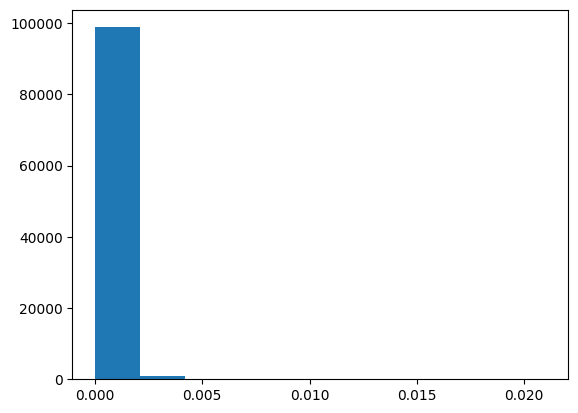

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.hist(pair_term_enc_df.sum(axis = 1))
plt.show()

In [ ]:
## density で filtering
import heapq
def nth_largest(n: int, numbers: list):
    return heapq.nlargest(n, numbers)[-1]
#
threshold = 100
lowest_density = nth_largest(threshold, pair_term_enc_df.sum(axis = 1))
size0 = len(pair_term_enc_df)
pair_term_enc_df_filtered = pair_term_enc_df[ pair_term_enc_df.sum(axis = 1) > lowest_density ]
size1 = len(pair_term_enc_df_filtered)
print(f"{size1} rows remain, discarding {size0 - size1} rows")

99 rows remain, discarding 99901 rows


In [ ]:
## sampling term_enc_df for hc
term_hc_sampling_rate = 1.0
sampled_pair_term_enc_df = \
    pair_term_enc_df_filtered.sample(round(len(pair_term_enc_df_filtered) * term_hc_sampling_rate))
#
sampled_pair_term_enc_df.sample(10)

,0,1,2,3,4,5,6,7,8,9,...,80,81,82,83,84,85,86,87,88,89
m…r :: m…ɹ,0.000000e+00,5.643373e-04,1.808426e-07,6.085414e-06,0.000000e+00,0.000002,4.172054e-06,8.664146e-07,1.639827e-05,6.433386e-05,...,1.074707e-07,4.816231e-06,3.360558e-04,0.000154,2.785547e-06,1.633787e-05,2.689439e-05,9.202253e-07,7.965083e-06,3.698349e-04
e…i :: ɛ…i,0.000000e+00,0.000000e+00,0.000000e+00,1.628176e-05,7.366511e-08,0.000025,0.000000e+00,1.941369e-07,5.317877e-05,0.000000e+00,...,3.529016e-05,0.000000e+00,0.000000e+00,0.000000,1.258291e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.032798e-05
i…l :: ɪ…ɫ,2.124096e-04,3.920159e-05,1.357896e-04,0.000000e+00,1.143035e-03,0.000023,2.387759e-04,2.576398e-05,0.000000e+00,1.349982e-04,...,2.658599e-04,8.949240e-07,6.944331e-05,0.000054,8.210010e-06,6.868648e-08,4.525572e-05,1.480647e-05,2.991373e-06,1.669470e-08
i…r :: ɪ…ɝ,7.920018e-05,4.176907e-04,1.157443e-04,8.193713e-07,3.243858e-04,0.000077,1.615587e-04,1.791992e-05,6.541989e-06,1.832389e-05,...,7.068429e-07,0.000000e+00,4.964127e-06,0.000137,4.824757e-05,2.678420e-05,2.247031e-05,7.746429e-05,8.172353e-05,1.614360e-05
a…t :: æ…t,7.962698e-06,9.070023e-08,5.134625e-04,8.629297e-07,1.218663e-05,0.000020,0.000000e+00,4.580681e-06,6.290992e-08,9.833271e-05,...,5.473219e-08,0.000000e+00,1.120092e-07,0.000017,0.000000e+00,8.950991e-05,0.000000e+00,9.620808e-04,5.649027e-06,9.625130e-08
l…e :: ɫ…ɪ,3.212974e-04,2.357377e-06,1.220711e-05,2.588271e-05,4.576630e-05,0.000023,1.553994e-07,0.000000e+00,1.828799e-06,2.499615e-06,...,1.083700e-03,3.759953e-06,7.220558e-08,0.000000,2.722335e-07,4.630473e-05,7.891974e-06,3.662256e-06,3.258362e-08,1.091036e-07
i…e :: ɹ…ɪ,0.000000e+00,7.503011e-06,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,1.290081e-05,6.371999e-08,6.111693e-07,0.000000e+00,...,1.029427e-06,2.651590e-06,2.526180e-07,0.000000,0.000000e+00,0.000000e+00,8.605149e-08,1.609791e-05,1.231810e-05,1.430776e-06
b…t :: b…t,1.204343e-08,0.000000e+00,0.000000e+00,7.229040e-06,9.328769e-07,0.000044,2.298711e-06,1.765653e-06,3.852621e-06,3.529086e-07,...,4.522642e-05,2.309355e-04,0.000000e+00,0.000003,0.000000e+00,0.000000e+00,0.000000e+00,1.463579e-04,0.000000e+00,1.880785e-07
c…t :: k…t,0.000000e+00,1.803969e-04,3.250141e-04,0.000000e+00,0.000000e+00,0.000754,0.000000e+00,1.927859e-04,0.000000e+00,2.355148e-04,...,2.714060e-05,3.672162e-05,7.093469e-05,0.000000,1.919850e-06,7.913940e-07,1.580162e-07,6.417155e-05,3.122849e-05,1.825542e-04
a…n :: æ…n,0.000000e+00,0.000000e+00,6.113876e-06,1.559258e-08,0.000000e+00,0.000000,0.000000e+00,2.223824e-08,0.000000e+00,4.653923e-05,...,1.492441e-08,0.000000e+00,0.000000e+00,0.000006,1.274256e-08,3.144035e-07,1.543553e-05,1.003077e-04,1.281680e-06,0.000000e+00


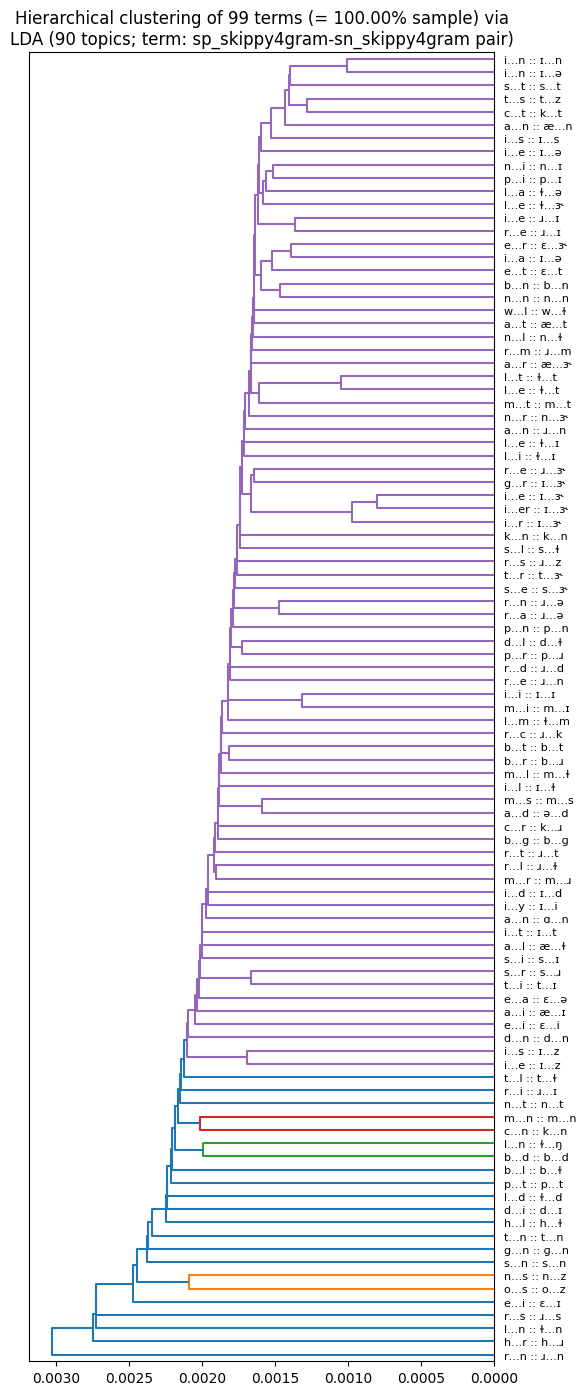

In [ ]:
## term = pair の階層クラスタリングの実行
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

## 日本語表示のための設定
#plt.rcParams["font.family"] = "Hiragino sans" # Windows/Linux では別のフォントを指定
## 変数名の変更
hc_df = sampled_pair_term_enc_df

## 描画サイズの指定
plt.figure(figsize = (6, round(10 * len(hc_df) * 0.017))) # This needs to be run here, before dendrogram construction.

## 距離行列の構築
linkage_methods = [ 'centroid', 'median', 'ward' ]
linkage_method = linkage_methods[-1]
#pair_linkage = linkage(hc_df, method = linkage_method, metric = 'euclidean')
pair_linkage = linkage(hc_df, metric = 'euclidean')

## 事例ラベルの生成
max_term_length = max([ len(x) for x in list(hc_df.index)])
label_vals = [ x[:max_term_length] for x in list(hc_df.index) ] # truncate doc keys
## 樹状分岐図の作成
dendrogram(pair_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 8)

## 題の指定
term_df_size = len(hc_df)
hc_sampling_rate = f"{100 * term_hc_sampling_rate:.2f}"
#domain_names = ', '.join(selected_domains.keys())
title_header = f"Hierarchical clustering of {term_df_size} terms (= {hc_sampling_rate}% sample) via\n"
title_body = f"LDA ({n_topics} topics; term: {sp_term_type}-{sn_term_type} pair)"
title_val = title_header + title_body
plt.title(title_val)
plt.show()